In [17]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [18]:
%reload_ext autoreload
%autoreload 2

In [19]:
import os
import sys
spark_home = os.environ['SPARK_HOME'] = '/home/cloudera/spark-1.6.0-bin-hadoop2.6/'
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.9-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by <module> at <ipython-input-12-6db038b620e8>:8 

# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW11


---
__Name:__  Sahab Aslam  
__Class:__ MIDS w261 (Section Fall 2016)     
__Email:__  sahab@iSchool.Berkeley.edu     
__Week:__   11

# Table of Contents <a name="TOC"></a> 

1.  [HW Intructions](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    HW11.0.  [Broadcast versus Caching in Spark ](#HW11.0)    
    HW11.1.  [HW11.2 Gradient descent](#HW11.1)   
    HW11.2.  [Gradient descent](#HW11.2)    
    HW11.3.  [Logistic Regression](#HW11.3)    
    HW11.4.  [SVMs](#HW11.4)  
    HW11.5.  [OPTIONAL  Distributed Perceptron algorithm](#HW11.5)  
    HW11.6.  [OPTIONAL  Evalution of perceptron algorihtms on PennTreeBank POS corpus](#HW11.6)  
    HW11.7.  [OPTIONAL Kernal Adatron](#HW11.7)
   
    HW11.8.  [OPTIONAL Create an animation of gradient descent for the Perceptron](#HW11.8)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)

MIDS UC Berkeley, Machine Learning at Scale
DATSCIW261 ASSIGNMENT #11

Version 2016-07-27 (FINAL)


 === INSTRUCTIONS for SUBMISSIONS ===
Follow the instructions for submissions carefully.

https://docs.google.com/forms/d/1ZOr9RnIe_A06AcZDB6K1mJN4vrLeSmS2PD6Xm3eOiis/viewform?usp=send_form 




<a name="3">
# HW Problems
[Back to Table of Contents](#TOC)

<a name="HW11.0"></a><h2 style="color:darkblue"> HW11.0: Broadcast versus Caching in Spark </h2>
[Back to Table of Contents](#TOC)


HW11.0  

Q: __What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.__

Q: __Review the following Spark-notebook-based implementation of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes:

Notebook
https://www.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb?dl=0

Notebook via NBViewer
http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb


## ANSWER

When we Cache data, Spark keeps it in memory for processing it multiple times. This data is usually fixed, like labels and feature values of training data set. But many times we need to update the values of some variables, like weights in regression, alpha/beta in gradient decents, centroids in Kmeans etc. When we broadcast data, we send the data to all worker nodes, and this will allow worker nodes to access new updated values of those variables. Example of centroid beings broadcasted is shown below.

Iteration0
[[ 0.83685089  0.45753654]
 [ 3.93445664  2.64740594]
 [ 2.17139639  5.7322322 ]]


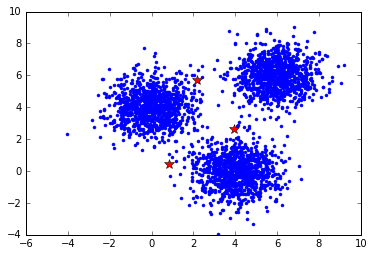

Iteration1
[[ 1.47740025  1.080261  ]
 [ 5.19706352  2.28775601]
 [ 2.61100575  5.47067913]]


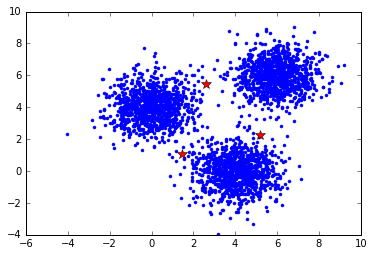

Iteration2
[[ 1.5345484   1.3587906 ]
 [ 5.46618561  2.14289712]
 [ 3.08795362  5.61091607]]


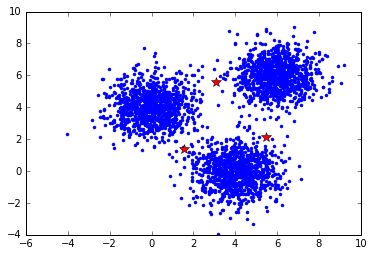

Iteration3
[[ 1.16092689  1.93464929]
 [ 5.27110421  1.37144825]
 [ 4.06418811  5.86052257]]


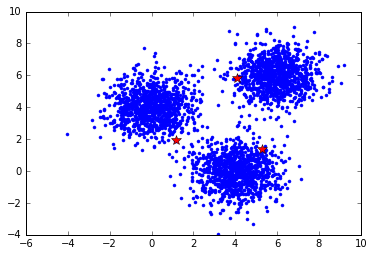

Iteration4
[[ 0.26549073  3.36184064]
 [ 4.34818488 -0.02434211]
 [ 5.60406406  6.01746874]]


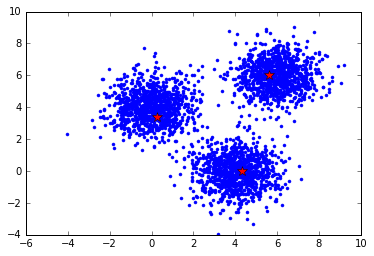

Iteration5
[[ 0.01137442  3.98696521]
 [ 4.05280803 -0.06414717]
 [ 5.93538476  6.00409306]]


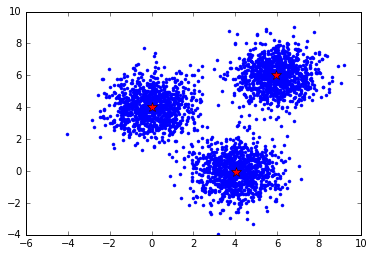

Iteration6
[[  4.54033547e-03   4.01505752e+00]
 [  4.03433350e+00  -5.29242830e-02]
 [  5.94610474e+00   6.00325022e+00]]


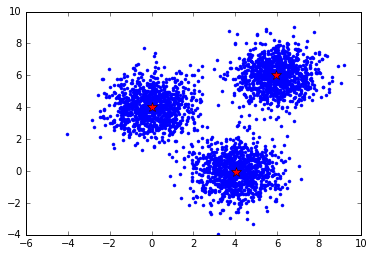

Final Results:
[[  4.54033547e-03   4.01505752e+00]
 [  4.03433350e+00  -5.29242830e-02]
 [  5.94610474e+00   6.00325022e+00]]


In [96]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.csv',data,delimiter = ',')
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    ###
    
    ###  CHANGE: Use broadcastedCentroids
    
    ####
    closest_centroid_idx = np.sum((x - broadcastedCentroids.value)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()
    
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):
    ###
    ###
    ###    Addded this line for broadcasting centroids    
    ##
    broadcastedCentroids = sc.broadcast(centroids)
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    ###
    ###
    ###    Addded this line for broadcasting centroids    
    ##
    if np.sum(np.absolute(centroids_new-broadcastedCentroids.value))<0.01:
        break
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    print centroids
    plot_iteration(centroids)
print "Final Results:"
print centroids

<a name="HW11.1"> <h2 style="color:darkgreen">HW11.1 Loss Functions</h2>
[Back to Table of Contents](#TOC)

 
In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm? 

In your reponse, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.


In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm? 


## Answer

Logistic regression minmizes the log loss. When we use L2 penalized logistic regression, we try to balance data fit against the magnitude of the coefficients. We determine the class or label of a new or test data point on it's probability of being higher or lower than 0.5 by evaluating against logistic curve.

Wheras we use SVM to fit a hyperplane that maximizes the distance between the classes based on the data points at the edge of each class. We determine the class or label of a new or test data point on which side of the plane it falls on by evaluating against the hyperplane.

Perceptron finds a hyperplane that separate the two sets but once it finds the hyperplane it stops.

All three would yield different boundaries depending on the data.

<a name="HW11.2"><h2 style="color:darkgreen">HW11.2 Gradient descent</h2>
[Back to Table of Contents](#TOC)

In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?

Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)


## Answer

Penalized loss functions help prevent overfitting. Three flavors (all supported by spark mllib) of penalized loss function are:

L1 norm (Lasso): $\left \| \mathbf{w}\right \|_1$. It can shrink some coefficients to zero, performing variable selection.
    
L2 (Ridge): $\frac{1}{2}\left \| \mathbf{w}\right \|_2^2$ It shrinks all the coefficient by the same proportions but eliminates none.
    
L1 & L2 (elastic): It is a weighted combination of both L1 and L2.

http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions

Probablistic Inrepretations:

L1 usually corresponds to setting a Laplacean prior on the regression coefficients - and picking a maximum a posteriori hypothesis. L2 similarly corresponds to Gaussian prior. As one moves away from zero, the probability for such a coefficient grows progressively smaller.

Source: https://www.quora.com/What-is-the-difference-between-L1-and-L2-regularization

    
    

In the context of logistic regression describe and define three flavors of penalized loss functions. Are these all supported in Spark MLLib (include online references to support your answers)?



<a name="HW11.3"> <h2 style="color:darkblue"> HW11.3 Logistic Regression</h2>
[Back to Table of Contents](#TOC)

Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.



```
Modify this data generation code to generating non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. 

NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets.

Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words. 

Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm . 

Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): 

>weight(X)= 1/||X||, 

>where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2)

>Here X is vector made up of X1 and X2.

Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.

Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set. 

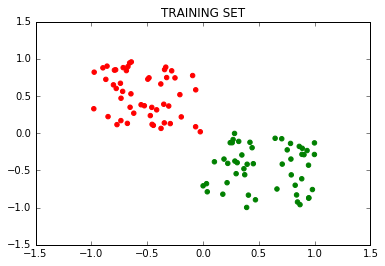

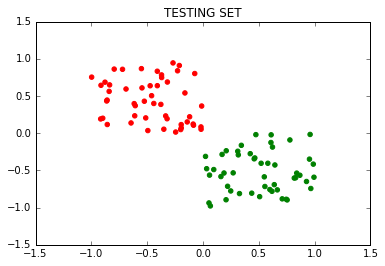

In [161]:
#linear separable data
from numpy.random import rand
def generateData(n):
     """ 
      generates a 2D linearly separable dataset with n samples. 
      The third element of the sample is the label
     """
     xb = (rand(n)*2-1)/2-0.5
     yb = (rand(n)*2-1)/2+0.5
     xr = (rand(n)*2-1)/2+0.5
     yr = (rand(n)*2-1)/2-0.5
     inputs = []
     for i in range(len(xb)):
      inputs.append([xb[i],yb[i],1])
      inputs.append([xr[i],yr[i],-1])
     return inputs

    #[[-0.071520556663525636, 0.79657398689553194, 1], [0.51929082541636185, -0.14104343144316933, -1],.......]

import matplotlib.pyplot as plt
%matplotlib inline 
trainingData = generateData(50)
testingData = generateData(50)



#plt.subplot(1, 2, 1)
plt.scatter([d[0] for d in trainingData], [d[1] for d in trainingData], color = ['r' if d[2]==1 else 'g' for d in trainingData])
plt.title('TRAINING SET')
plt.show()
plt.scatter([d[0] for d in testingData], [d[1] for d in testingData], color = ['r' if d[2]==1 else 'g' for d in testingData])
plt.title('TESTING SET')
plt.show()

#plt.subplot(1,2, 2)
#plt.scatter(testingData[:,0], testingData[:,1], color = red, alpha = 0.5)


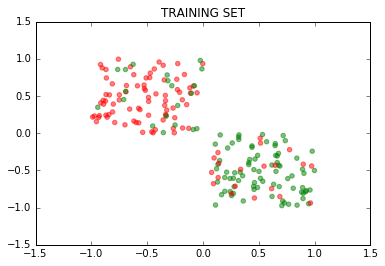

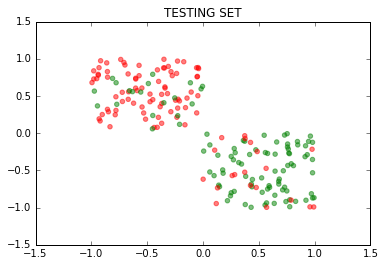

In [162]:
def generateData2(n):
     """ 
      generates a 2D linearly separable dataset with n samples. 
      The third element of the sample is the label
     """
     xb = (rand(n)*2-1)/2-0.5
     yb = (rand(n)*2-1)/2+0.5
     xr = (rand(n)*2-1)/2+0.5
     yr = (rand(n)*2-1)/2-0.5
     inputs = []
     for i in range(80):
      inputs.append([xb[i],yb[i],1])
      inputs.append([xr[i],yr[i],-1])
     for i in range(80,100):
      inputs.append([xb[i],yb[i],-1])
      inputs.append([xr[i],yr[i],1])
     return inputs

    #[[-0.071520556663525636, 0.79657398689553194, 1], [0.51929082541636185, -0.14104343144316933, -1],.......]

import matplotlib.pyplot as plt
%matplotlib inline 
trainingData = generateData2(100)
testingData = generateData2(100)



#plt.subplot(1, 2, 1)
plt.scatter([d[0] for d in trainingData], [d[1] for d in trainingData], color = 
            ['r' if d[2]==1 else 'g' for d in trainingData], alpha = 0.5)
plt.title('TRAINING SET')
plt.show()
plt.scatter([d[0] for d in testingData], [d[1] for d in testingData], color = ['r' if d[2]==1 else 'g' for d in testingData], alpha = 0.5)
plt.title('TESTING SET')
plt.show()

In [108]:
!%spark.pyspark

import functools
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD

/bin/sh: line 0: fg: no job control


In [163]:
#https://spark.apache.org/docs/1.1.0/mllib-linear-methods.html
# Load and parse the data
def parsePoint(point):
    #values = [float(x) for x in line.split(' ')]
    #the negative label is represented by 0 in 
    #MLlib instead of −1, to be consistent with multiclass labeling
    return LabeledPoint(0 if point[2] == -1 else 1, [point[0], point[1]])

#print parsePoint(trainingData)
#trainingData[0]

train_data = sc.parallelize(trainingData)
parsedData = train_data.map(parsePoint)

test_data = sc.parallelize(testingData)
parsedTestData = test_data.map(parsePoint)

accuracyWithIteration = []

for i in range(1,30):
    # Build the model
    model = LogisticRegressionWithSGD.train(parsedData, regType='l1', intercept=True, iterations=i)

    # Evaluating the model on training data
    labelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    accuracyWithIteration.append((i, trainErr))
    print"Training Error = " ,  str(trainErr), " for iteration " , i


Training Error =  0.5  for iteration  1
Training Error =  0.5  for iteration  2
Training Error =  0.48  for iteration  3
Training Error =  0.375  for iteration  4
Training Error =  0.29  for iteration  5
Training Error =  0.26  for iteration  6
Training Error =  0.245  for iteration  7
Training Error =  0.22  for iteration  8
Training Error =  0.215  for iteration  9
Training Error =  0.205  for iteration  10
Training Error =  0.205  for iteration  11
Training Error =  0.205  for iteration  12
Training Error =  0.205  for iteration  13
Training Error =  0.21  for iteration  14
Training Error =  0.21  for iteration  15
Training Error =  0.21  for iteration  16
Training Error =  0.215  for iteration  17
Training Error =  0.21  for iteration  18
Training Error =  0.205  for iteration  19
Training Error =  0.205  for iteration  20
Training Error =  0.205  for iteration  21
Training Error =  0.205  for iteration  22
Training Error =  0.205  for iteration  23
Training Error =  0.205  for ite

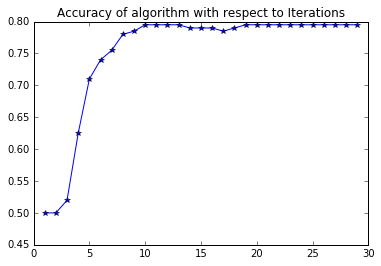

In [164]:
#separate list
plt.plot([x[0]for x in accuracyWithIteration], [1- x[1]for x in accuracyWithIteration], '-*')
plt.title('Accuracy of algorithm with respect to Iterations')
#print accuracyWithIteration

In [ ]:
import itertools
#https://spark.apache.org/docs/1.1.0/mllib-linear-methods.html
# Load and parse the data
def parsePointLasso(point):
    #print "l"
    x = weight(point)
    #the negative label is represented by 0 in 
    #MLlib instead of −1, to be consistent with multiclass labeling
    return LabeledPoint(0 if point[2] == -1 else 1, x)

def weight(values):
    return [values[:2]/np.sqrt(np.sum(np.array(values[:2])**2))]

train_data = sc.parallelize(trainingData)
parsedData = train_data.map(parsePointLasso)
test_data = sc.parallelize(testingData)
parsedTestData = test_data.map(parsePoint)
#d = train_data .map(lambda x: weight(x[0], x[1]))

#stop condition
oldWeights= [float('inf')]*3

for i in range(1,35):

    model = LogisticRegressionWithSGD.train(parsedData, regType='l2', intercept=True, iterations=i)

    labelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    accuracyWithIteration.append((i, 1-trainErr))
    print"Training Error = " ,  str(trainErr), " for iteration " , i
    
    
    ##for stop criteria 
    
    weights = [model.weights[0], model.weights[1], model.intercept]
    
    if( (weights[0]/weights[1]  - oldWeights[0]/oldWeights[1] )< .01 ):
        break
    
    oldWeight = weights
    #print d.take(40)
#separate list
#weird graph!!
plt.plot([m[0]for m in accuracyWithIteration], [1- m[1]for m in accuracyWithIteration], '-*')
plt.title('Accuracy of algorithm with respect to Iterations')
#print accuracyWithIteration





Training Error =  0.5  for iteration  1
Training Error =  0.5  for iteration  2
Training Error =  0.435  for iteration  3
Training Error =  0.32  for iteration  4
Training Error =  0.275  for iteration  5
Training Error =  0.255  for iteration  6
Training Error =  0.23  for iteration  7
Training Error =  0.22  for iteration  8
Training Error =  0.205  for iteration  9
Training Error =  0.21  for iteration  10
Training Error =  0.205  for iteration  11
Training Error =  0.205  for iteration  12
Training Error =  0.205  for iteration  13
Training Error =  0.21  for iteration  14
Training Error =  0.21  for iteration  15
Training Error =  0.21  for iteration  16
Training Error =  0.21  for iteration  17
Training Error =  0.215  for iteration  18
Training Error =  0.215  for iteration  19
Training Error =  0.21  for iteration  20
Training Error =  0.205  for iteration  21
Training Error =  0.205  for iteration  22
Training Error =  0.205  for iteration  23
Training Error =  0.205  for iter

<a name="HW11.4"><h2 style="color:darkblue"> HW11.4 SVMs  </h2>
[Back to Table of Contents](#TOC)

Use the non-linearly separable training and testing datasets from HW11.3 in this problem.

Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. 



In [81]:
from pyspark.mllib.classification import SVMWithSGD

#train_data = sc.parallelize(trainingData)
#parsedData = train_data.map(parsePoint)

#test_data = sc.parallelize(testingData)
#parsedTestData = test_data.map(parsePoint)

errors = []
#model = SVMWithSGD.train(parsedData, regType='l1', intercept=True, iterations=1)
for i in range(1,30):
    # Build the model
    model = SVMWithSGD.train(parsedData, regType='l1', intercept=True, iterations=i)

    # Evaluating the model on training data
    labelsAndPreds = parsedTestData.map(lambda p: (p.label, model.predict(p.features)))
    trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedTestData.count())
    errors.append(trainErr)
    print"Training Error = " ,  str(trainErr), " for iteration " , i


Training Error =  0.5  for iteration  1
Training Error =  0.475  for iteration  2
Training Error =  0.335  for iteration  3
Training Error =  0.265  for iteration  4
Training Error =  0.235  for iteration  5
Training Error =  0.22  for iteration  6
Training Error =  0.205  for iteration  7
Training Error =  0.205  for iteration  8
Training Error =  0.2  for iteration  9
Training Error =  0.2  for iteration  10
Training Error =  0.2  for iteration  11
Training Error =  0.2  for iteration  12
Training Error =  0.2  for iteration  13
Training Error =  0.2  for iteration  14
Training Error =  0.2  for iteration  15
Training Error =  0.2  for iteration  16
Training Error =  0.2  for iteration  17
Training Error =  0.2  for iteration  18
Training Error =  0.2  for iteration  19
Training Error =  0.2  for iteration  20
Training Error =  0.2  for iteration  21
Training Error =  0.2  for iteration  22
Training Error =  0.2  for iteration  23
Training Error =  0.2  for iteration  24
Training Err

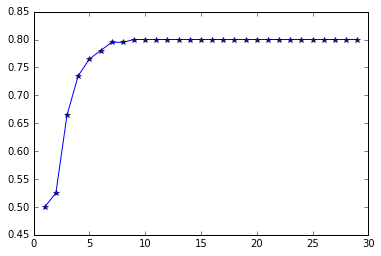

In [85]:
iterations = [i for i in range(1,30)]
accuracy = [1-i for i in errors]
plt.plot(iterations, accuracy, '-*')
plt.title('Accuracy of algorithm with respect to Iterations')